## College Factors Impact on NBA Players' Guaranteed Contract Value

In the previous notebook, we extracted draft history form NBA API and college stats from Sports Reference and merged on player name. In this notebook, we'll finish cleaning and prepare the data for regression analysis. 

# 1. Import Libraries

In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import os
import re
import time
import pickle
import requests
import seaborn as sns
import statsmodels as sm
import sys
from nba_api.stats.static import teams
from nba_api.stats.static import players
import requests
from nba_api.stats.endpoints import drafthistory
import urllib.request as urllib2
import string
from bs4 import BeautifulSoup as bsoup
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import scipy as stats
import statsmodels.api as sma

# 2. Import Data

In [2]:
# DEFINE PATH WHERE NOTEBOOK FILES ARE STORED

path = r"C:\Users\ahigh\OneDrive\Desktop\team24_milestone1\Draft files"
reg_df = pd.read_csv( path + r"\reg_df.csv")
reg_df

,original_name,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,...,Number of College Teams,Current_Contract,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,ORGANIZATION,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK
0,aaron-gordon,38,38.0,1187.0,189,382,173.0,337.0,16.0,45.0,...,1,22266182.0,Orlando,Magic,ORL,Arizona,2014,1.0,4.0,4.0
1,aaron-holiday,101,65.0,3209.0,476,1058,296.0,631.0,180.0,427.0,...,1,2019706.0,Indiana,Pacers,IND,California-Los Angeles,2018,1.0,23.0,23.0
2,aaron-nesmith,46,33.0,1428.0,219,496,100.0,206.0,119.0,290.0,...,1,5634257.0,Boston,Celtics,BOS,Vanderbilt,2020,1.0,14.0,14.0
3,aaron-wiggins,96,50.0,2707.0,375,922,203.0,445.0,172.0,477.0,...,1,1836096.0,Oklahoma City,Thunder,OKC,Maryland,2021,2.0,25.0,55.0
4,aj-griffin,39,25.0,935.0,146,296,75.0,137.0,71.0,159.0,...,1,3712920.0,Atlanta,Hawks,ATL,Duke,2022,1.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,zach-collins,39,0.0,673.0,135,207,125.0,186.0,10.0,21.0,...,1,7700000.0,Sacramento,Kings,SAC,Gonzaga,2017,1.0,10.0,10.0
336,zach-lavine,37,1.0,904.0,127,288,79.0,160.0,48.0,128.0,...,1,40064220.0,Minnesota,Timberwolves,MIN,California-Los Angeles,2014,1.0,13.0,13.0
337,zeke-nnaji,32,32.0,981.0,179,314,174.0,297.0,5.0,17.0,...,1,4306281.0,Denver,Nuggets,DEN,Arizona,2020,1.0,22.0,22.0
338,ziaire-williams,20,14.0,558.0,76,203,53.0,124.0,23.0,79.0,...,1,4810200.0,New Orleans,Pelicans,NOP,Stanford,2021,1.0,10.0,10.0


# 3. Assess Dataframe

Becuase much of the data cleaning was complete in the previous notebook, we shouldn't need to do much. We will, however:

- Check for missing values and drop records appropriately
- Check for duplicates and drop records appropriately
- Review data types 
- Rename columns for context

In [3]:
# THE FILE WE'RE USING FOR THE REGRESSION ANALYSIS IS ONLY A SUBSET OF THE OIRGINAL SOURCE FILE - WE NEED TO MAKE SURE WE HAVE COLLEGE STATS AND CONTRACT VALUES FOR EACH PLAYER

reg_df.isnull().sum()

original_name                0
G                            0
GS                           0
MP                           0
FG                           0
FGA                          0
2P                           0
2PA                          0
3P                           0
3PA                          0
FT                           0
FTA                          0
ORB                          0
DRB                          0
TRB                          0
AST                          0
STL                          0
BLK                          0
TOV                          0
PF                           0
PTS                          0
Number of College Seasons    0
Number of College Teams      0
Current_Contract             1
TEAM_CITY                    0
TEAM_NAME                    0
TEAM_ABBREVIATION            0
ORGANIZATION                 0
SEASON                       0
ROUND_NUMBER                 0
ROUND_PICK                   0
OVERALL_PICK                 0
dtype: i

There is one player without a contract value, he is the only player we need to drop from the existing dataframe. 

In [32]:
reg_df = reg_df[reg_df['Current_Contract'].notna()] #KEEP WHERE CONTRACT VALUE IS NOT MISSINGE
reg_df.isnull().sum()

original_name                0
G                            0
GS                           0
MP                           0
FG                           0
FGA                          0
2P                           0
2PA                          0
3P                           0
3PA                          0
FT                           0
FTA                          0
ORB                          0
DRB                          0
TRB                          0
AST                          0
STL                          0
BLK                          0
TOV                          0
PF                           0
PTS                          0
Number of College Seasons    0
Number of College Teams      0
Current_Contract             0
TEAM_CITY                    0
TEAM_NAME                    0
TEAM_ABBREVIATION            0
ORGANIZATION                 0
SEASON                       0
ROUND_NUMBER                 0
ROUND_PICK                   0
OVERALL_PICK                 0
dtype: i

In [5]:
# NEED TO DOUBLE CHECK THAT THERE ARE NOT ANY DUPLICATE RECORDS

reg_df['original_name'].value_counts(dropna=False)

original_name
aaron-gordon         1
shake-milton         1
marvin-bagley iii    1
markieff-morris      1
markelle-fultz       1
                    ..
grayson-allen        1
grant-williams       1
gradey-dick          1
gordon-hayward       1
zion-williamson      1
Name: count, Length: 339, dtype: int64

Many of our vairables should be numeric (either intergers or floats), the categorical values (organization and team info) will later be converted to dummy variables. 

In [6]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 0 to 339
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   original_name              339 non-null    object 
 1   G                          339 non-null    int64  
 2   GS                         339 non-null    float64
 3   MP                         339 non-null    float64
 4   FG                         339 non-null    int64  
 5   FGA                        339 non-null    int64  
 6   2P                         339 non-null    float64
 7   2PA                        339 non-null    float64
 8   3P                         339 non-null    float64
 9   3PA                        339 non-null    float64
 10  FT                         339 non-null    int64  
 11  FTA                        339 non-null    int64  
 12  ORB                        339 non-null    float64
 13  DRB                        339 non-null    float64
 14 

Some of us are not basketball aficionados, so some of the variable names are less obvious. We'll rename those as a reminder of what they mean. And adjust some others for simplicity. 

In [7]:
stats_name = {'G' :'GAMES',
              'GS' : 'GAMES_STARTED',
              'MP': 'MINS_PLAYED',
              'FG' : 'FIELD_GOAL',
              'FGA': 'FIELD_GOAL_ATMPTS',
              '2P' : '2P_FIELD_GOAL',
              '2PA' : '2P_FIELD_GOAL_ATMPTS',
              '3P' : '3P_FIELD_GOAL',
              '3PA' : '3P_FIELD_GOAL_ATMPTS',
              'FT' : 'FREE_THROW',
              'FTA': 'FREE_THROW_ATMPTS',
              'ORB': 'OFF_RBNDS',
              'DRB': 'DEF_RBNDS',
              'TRB': 'TOT_RBNDS',
              'original_name': 'NAME',
              'Number of College Seasons' : 'COLL_SEASONS',
              'Number of College Teams' : 'COLL_TEAMS',
              'ORGANIZATION' : 'DRAFT_SCHOOL',
              'Current_Contract' : 'CONTRACT_VAL'}

reg_df1 = reg_df.rename(columns=stats_name)
reg_df1

,NAME,GAMES,GAMES_STARTED,MINS_PLAYED,FIELD_GOAL,FIELD_GOAL_ATMPTS,2P_FIELD_GOAL,2P_FIELD_GOAL_ATMPTS,3P_FIELD_GOAL,3P_FIELD_GOAL_ATMPTS,...,COLL_TEAMS,CONTRACT_VAL,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,DRAFT_SCHOOL,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK
0,aaron-gordon,38,38.0,1187.0,189,382,173.0,337.0,16.0,45.0,...,1,22266182.0,Orlando,Magic,ORL,Arizona,2014,1.0,4.0,4.0
1,aaron-holiday,101,65.0,3209.0,476,1058,296.0,631.0,180.0,427.0,...,1,2019706.0,Indiana,Pacers,IND,California-Los Angeles,2018,1.0,23.0,23.0
2,aaron-nesmith,46,33.0,1428.0,219,496,100.0,206.0,119.0,290.0,...,1,5634257.0,Boston,Celtics,BOS,Vanderbilt,2020,1.0,14.0,14.0
3,aaron-wiggins,96,50.0,2707.0,375,922,203.0,445.0,172.0,477.0,...,1,1836096.0,Oklahoma City,Thunder,OKC,Maryland,2021,2.0,25.0,55.0
4,aj-griffin,39,25.0,935.0,146,296,75.0,137.0,71.0,159.0,...,1,3712920.0,Atlanta,Hawks,ATL,Duke,2022,1.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,zach-collins,39,0.0,673.0,135,207,125.0,186.0,10.0,21.0,...,1,7700000.0,Sacramento,Kings,SAC,Gonzaga,2017,1.0,10.0,10.0
336,zach-lavine,37,1.0,904.0,127,288,79.0,160.0,48.0,128.0,...,1,40064220.0,Minnesota,Timberwolves,MIN,California-Los Angeles,2014,1.0,13.0,13.0
337,zeke-nnaji,32,32.0,981.0,179,314,174.0,297.0,5.0,17.0,...,1,4306281.0,Denver,Nuggets,DEN,Arizona,2020,1.0,22.0,22.0
338,ziaire-williams,20,14.0,558.0,76,203,53.0,124.0,23.0,79.0,...,1,4810200.0,New Orleans,Pelicans,NOP,Stanford,2021,1.0,10.0,10.0


## 3. Exploratory Analysis

Now that we have a cleaned dataset, we can start exploring trends in the data. Since most of the variables are numeric, we can start by analyzing some descriptive statistics.

In [8]:
reg_df1['CONTRACT_VAL'].median()
reg_df1.describe().round()

,GAMES,GAMES_STARTED,MINS_PLAYED,FIELD_GOAL,FIELD_GOAL_ATMPTS,2P_FIELD_GOAL,2P_FIELD_GOAL_ATMPTS,3P_FIELD_GOAL,3P_FIELD_GOAL_ATMPTS,FREE_THROW,...,TOV,PF,PTS,COLL_SEASONS,COLL_TEAMS,CONTRACT_VAL,SEASON,ROUND_NUMBER,ROUND_PICK,OVERALL_PICK
count,339.0,339.0,339.0,339.0,339.0,339.0,339.0,339.0,339.0,339.0,...,339.0,339.0,339.0,339.0,339.0,339.0,339.0,339.0,339.0,339.0
mean,72.0,55.0,1979.0,316.0,658.0,236.0,442.0,78.0,212.0,183.0,...,128.0,154.0,892.0,2.0,1.0,11171678.0,2018.0,1.0,14.0,21.0
std,47.0,39.0,1371.0,218.0,455.0,174.0,315.0,84.0,218.0,128.0,...,90.0,107.0,607.0,1.0,0.0,11703780.0,4.0,0.0,9.0,15.0
min,3.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,1.0,1.0,92857.0,2005.0,1.0,1.0,1.0
25%,35.0,31.0,995.0,160.0,338.0,116.0,222.0,20.0,64.0,89.0,...,65.0,73.0,453.0,1.0,1.0,2532696.0,2015.0,1.0,6.0,9.0
50%,64.0,39.0,1689.0,271.0,569.0,189.0,371.0,49.0,144.0,156.0,...,105.0,128.0,761.0,2.0,1.0,5634257.0,2019.0,1.0,12.0,19.0
75%,104.0,70.0,2597.0,428.0,850.0,324.0,587.0,112.0,307.0,234.0,...,172.0,216.0,1175.0,3.0,1.0,16923913.0,2021.0,2.0,20.0,32.0
max,288.0,284.0,10618.0,1676.0,3690.0,1190.0,2320.0,486.0,1370.0,784.0,...,612.0,686.0,4414.0,5.0,3.0,51915615.0,2023.0,2.0,30.0,60.0


Text(0.5, 1.0, 'Distribution of Contract Value')

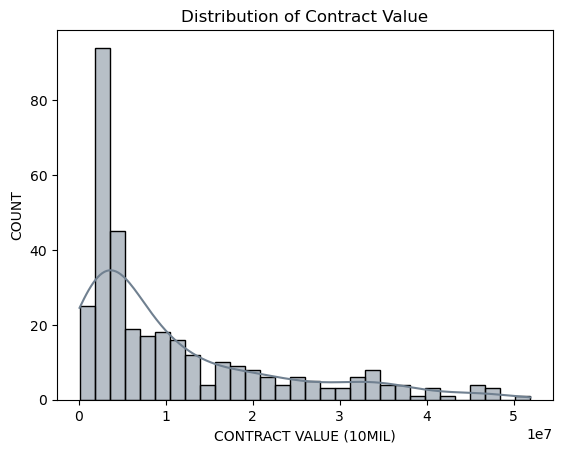

In [9]:
# VISUALIZE DISTRIBUTION OF CONTRACT VALUE

fig = sns.histplot(data=reg_df1, x='CONTRACT_VAL', kde=True, color="slategrey", bins=30)
fig.set(xlabel='CONTRACT VALUE (10MIL)', ylabel='COUNT')
fig.set_title('Distribution of Contract Value')

In [10]:
# CREATE BINARY VARIABLE FOR PLAYERS WHO PLAYED IN MORE THAN ONE COLLEGE SEASON

reg_df1['MORE_THN_1_COLL_SEASON'] = np.where(reg_df1['COLL_SEASONS']==1, 0,1)

Text(0.5, 1.0, 'Distribution of Contract Value for Players \n with One or More College Season')

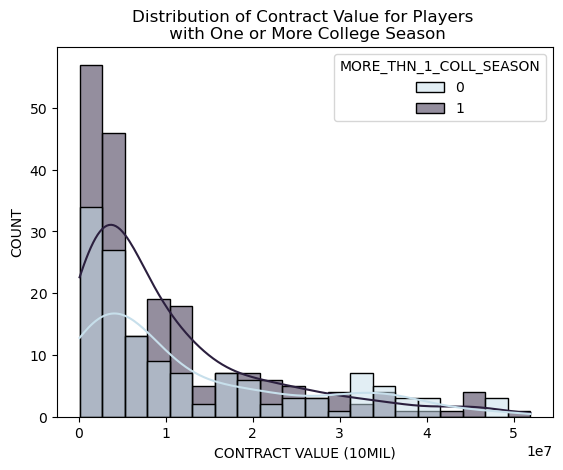

In [11]:
fig = sns.histplot(data=reg_df1, x='CONTRACT_VAL', kde=True, palette="ch:s=.25,rot=-.25", hue='MORE_THN_1_COLL_SEASON',bins=20) 
fig.set(xlabel='CONTRACT VALUE (10MIL)', ylabel='COUNT')
fig.set_title('Distribution of Contract Value for Players \n with One or More College Season')

The range of contract values is quite large, with a minimum value of $92,857 and a maximum value of $51,915,615. The overall median contract value is $2,532,696. As we can tell for from the distribution plot, most NBA players drafted from a college/university have a contract value less than 10 million. Very few players exceed 20 million. Additionally, we can tell that players that played more than one college season make less.

In [12]:
# MEDIAN CONTRACT VALUE OF PLAYERS BY COLLEGE
val_by_college = pd.pivot_table(reg_df1, index='DRAFT_SCHOOL',values='CONTRACT_VAL', aggfunc='median').sort_values(by='CONTRACT_VAL', ascending=False).rename(columns={'CONTRACT_VAL':'MED_CNTR_VAL'})

# COUNT OF PLAYERS BY COLLEGE
count_by_college = pd.pivot_table(reg_df1, index='DRAFT_SCHOOL',values='NAME', aggfunc='count').sort_values(by='NAME', ascending=False).rename(columns={'NAME':'PLYR_COUNT'}).reset_index()
count_by_college.head(10)
count_by_college['%'] =round(( (count_by_college['PLYR_COUNT']/ len(reg_df1)) * 100),1)

# MERGE DFS
by_college = pd.merge(count_by_college, val_by_college, how='outer',on='DRAFT_SCHOOL').sort_values(by='MED_CNTR_VAL', ascending=False).reset_index()
by_college[0:10]


,index,DRAFT_SCHOOL,PLYR_COUNT,%,MED_CNTR_VAL
0,88,Davidson,1,0.3,51915615.0
1,89,Fresno State,1,0.3,45640084.0
2,70,Weber State,1,0.3,45640084.0
3,77,New Mexico State,1,0.3,37893408.0
4,81,Lehigh,1,0.3,35802469.0
5,63,California,1,0.3,31830357.0
6,64,Butler,1,0.3,31500000.0
7,45,Oklahoma,2,0.6,29672030.5
8,94,Syracuse,1,0.3,27586207.0
9,36,Wake Forest,3,0.9,25340000.0


Text(0.5, 1.0, 'Number of Players Drafted by College/ University\n Top 10')

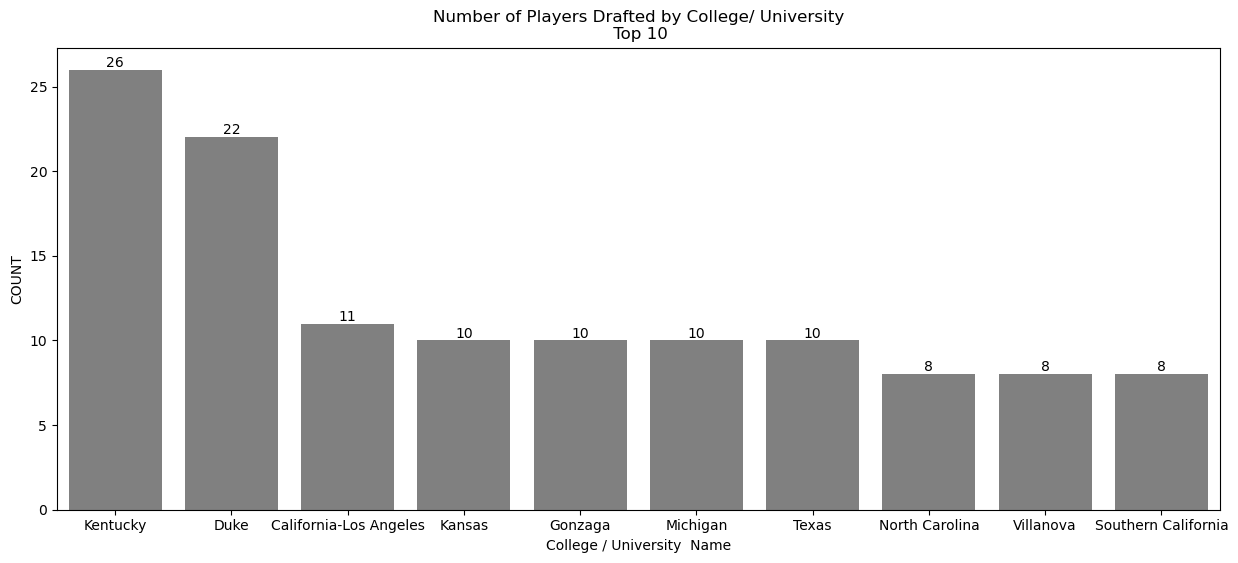

In [13]:
# CREAT BAR CHART FOR TOP 10 FEDER SCHOOLS
count_by_college.head(10)

fig, ax = plt.subplots(figsize=(15, 6))
 
# drawing the plot

fig = sns.barplot(count_by_college[0:10],x='DRAFT_SCHOOL',y='PLYR_COUNT',color='grey')
fig.bar_label(ax.containers[0], fontsize=10)
fig.set(xlabel='College / University  Name', ylabel='COUNT')
fig.set_title('Number of Players Drafted by College/ University\n Top 10')



In [14]:
#LOOK FOR A PATTERN BETWEEN SCHOOLS AND TEAMS, ARE THERE TEAMS THAT DRAFT FROM CERTAIN SCHOOLS MORE FREQUENTLY

team_school = pd.pivot_table(data =reg_df1, index=['TEAM_NAME','DRAFT_SCHOOL'], values='NAME', aggfunc='count')
school_team = pd.pivot_table(data =reg_df1, index=['DRAFT_SCHOOL','TEAM_NAME'], values='NAME', aggfunc='count')

The largest median contract value by school represents the salary of a single player. In fact, the schools with the highest contract values have the fewest number of players drafted.There are 97 unique colleges represented in our data. Of them, Kentucky and Duke appear to be the largest feeders to the NBA. Almost, 7.7% of active NBA players were drafted from Kentucky, 6.5% were drafted from Duke. Players drafted from Kentucy have a median contract value of $7,401,475.

In [15]:
# MEDIAN CONTRACT VALUE BY NUMBER OF COLLEGE SEASONS

pd.pivot_table(reg_df1, index='COLL_SEASONS',values='CONTRACT_VAL', aggfunc='median').sort_values(by='CONTRACT_VAL', ascending=False).rename(columns={'CONTRACT_VAL':'MED_CNTR_VAL'})

,MED_CNTR_VAL
COLL_SEASONS,
1,6250000.0
2,6093949.5
3,5000000.0
4,4779340.0
5,2000000.0


Maybe, not surprisingly - players who played few college season have higher contract values. The players who enter the draft after only one college season have the highest contract values. This suggests an inverse relationship between contract value and number of college seasons played. Additional college seasons may be an indication of players who need/want to improve their performance. 

In [16]:
# MEDIAN CONTRACT VALUE OF PLAYERS BY NBA TEAM THAT DRAFTED THEM
val_by_team = pd.pivot_table(reg_df1, index='TEAM_NAME',values='CONTRACT_VAL', aggfunc='median').sort_values(by='CONTRACT_VAL', ascending=False).rename(columns={'CONTRACT_VAL':'MED_CNTR_VAL'})

# COUNT OF PLAYERS BY TEAM
count_by_team = pd.pivot_table(reg_df1, index='TEAM_NAME',values='NAME', aggfunc='count').sort_values(by='NAME', ascending=False).rename(columns={'NAME':'PLYR_COUNT'})
count_by_team.head(10)

# MERGE DFS
by_team = pd.merge(count_by_team, val_by_team, how='outer',on='TEAM_NAME').sort_values(by='MED_CNTR_VAL', ascending=False)
by_team

,PLYR_COUNT,MED_CNTR_VAL
TEAM_NAME,,
SuperSonics,1,47649433.0
Bobcats,2,20644928.0
Pistons,10,12880149.0
Warriors,11,12119440.0
Bulls,11,11111111.0
Bucks,7,10900000.0
Celtics,13,10500000.0
Lakers,12,9187500.0
76ers,18,9125000.0


In [17]:
# COUNT OF PLAYERS BY TEAM
count_by_season = pd.pivot_table(reg_df1, index='SEASON',values='CONTRACT_VAL', aggfunc='median').sort_values(by='CONTRACT_VAL', ascending=False).rename(columns={'CONTRACT_VAL':'MED_CONTRT_VAL'})
count_by_season

,MED_CONTRT_VAL
SEASON,
2005,30800000.0
2009,28600000.0
2012,22321429.0
2014,20357143.0
2006,20348520.0
2016,19279841.0
2010,19151475.0
2017,17878571.5
2011,17817399.0


One cavaet when analyzing contract value by season (year of draft) and team, is that they represent different points of time. The contract value is for the 2023-24 season and the team is the NBA team that originally drafted
the player. Obviously, teams have varying budgets for what they can financially guaruantee and players can be traded to different teams throughout their NBA careers. Values by season has the most relevance for players drafted in 2023. Similary, the NBA team that drafted the player is likely different than the team that offered the contract. Some players were drafted to teams that are no longer active or have relocated. For example, the Seattle Supersonics relocated to Oklahoma City and became the Oklahoma City Thunder. As such, these values (season and team) will not be included in the regression analysis. 

Next, we'll standardize stats by the number of games. Current values of the college stat metrics are the sum across a player's college career. Most players played only one college season before they were drafted but there are many in our dataset that played between 2-4 seasons and a few who played five college seasons. To standardize the metrics across these groups of players, we'll convert the metrics to a "per-game" value. Additionally, for the metrics that represent attempts and success separately, we'll create a success rate for each. 

In [18]:
reg_df1['COLL_SEASONS'].value_counts(dropna=False)

COLL_SEASONS
1    135
2     86
3     57
4     56
5      5
Name: count, dtype: int64

In [19]:
# CREATE PER GAME STATS TO NORMALIZE VALUES 

stats_lst = ['GAMES_STARTED','MINS_PLAYED','FIELD_GOAL','FIELD_GOAL_ATMPTS','2P_FIELD_GOAL','2P_FIELD_GOAL_ATMPTS',
             '3P_FIELD_GOAL','3P_FIELD_GOAL_ATMPTS'	,'FREE_THROW','FREE_THROW_ATMPTS','OFF_RBNDS','DEF_RBNDS','TOT_RBNDS',
             'AST','STL','BLK','TOV','PF','PTS'] # METRIC SUM VAR NAMES

# FOR EACH SUM VALUE, WE'LL DIVIDE BY THE NUMBER OF GAMES 


def per_game_stats():
    reg_df2 = reg_df1.copy()
    for stat in stats_lst:
        #print(stat)
        reg_df2[stat +'_PG'] = reg_df2[stat]/ reg_df2['GAMES']
        reg_df2 = reg_df2.drop(stat, axis =1)

    return reg_df2

# FOR METRICS THAT REPRESENT ATTEMPTS AND SUCCESSES, WE'LL CREATE A 
def get_percent():
    per_game_stats()
    for stat in ['FIELD_GOAL','2P_FIELD_GOAL','3P_FIELD_GOAL','FREE_THROW']:
        reg_df2[stat + '%_PG'] = reg_df2[stat +'_PG'] / reg_df2[stat +'_ATMPTS_PG']


    return reg_df2


reg_df2 = per_game_stats()
reg_df2 = get_percent()



In [20]:
# DROP REDUNDANT/DEPENDENT COLS

reg_df3 = reg_df2.drop(['GAMES','TEAM_CITY', 'ROUND_NUMBER','TEAM_NAME', 'TEAM_ABBREVIATION','SEASON','FIELD_GOAL_PG', 'FIELD_GOAL_ATMPTS_PG','2P_FIELD_GOAL_PG', '2P_FIELD_GOAL_ATMPTS_PG',
                        '3P_FIELD_GOAL_PG','3P_FIELD_GOAL_ATMPTS_PG','FREE_THROW_PG', 'FREE_THROW_ATMPTS_PG','TOT_RBNDS_PG','ROUND_PICK'],axis=1)
reg_df3 # PREVIEW DATAFRAME
reg_df3.columns

Index(['NAME', 'COLL_SEASONS', 'COLL_TEAMS', 'CONTRACT_VAL', 'DRAFT_SCHOOL',
       'OVERALL_PICK', 'MORE_THN_1_COLL_SEASON', 'GAMES_STARTED_PG',
       'MINS_PLAYED_PG', 'OFF_RBNDS_PG', 'DEF_RBNDS_PG', 'AST_PG', 'STL_PG',
       'BLK_PG', 'TOV_PG', 'PF_PG', 'PTS_PG', 'FIELD_GOAL%_PG',
       '2P_FIELD_GOAL%_PG', '3P_FIELD_GOAL%_PG', 'FREE_THROW%_PG'],
      dtype='object')

In [21]:
reg_df3 # PREVIEW DF

,NAME,COLL_SEASONS,COLL_TEAMS,CONTRACT_VAL,DRAFT_SCHOOL,OVERALL_PICK,MORE_THN_1_COLL_SEASON,GAMES_STARTED_PG,MINS_PLAYED_PG,OFF_RBNDS_PG,...,AST_PG,STL_PG,BLK_PG,TOV_PG,PF_PG,PTS_PG,FIELD_GOAL%_PG,2P_FIELD_GOAL%_PG,3P_FIELD_GOAL%_PG,FREE_THROW%_PG
0,aaron-gordon,1,1,22266182.0,Arizona,4.0,0,1.000000,31.236842,2.684211,...,1.973684,0.894737,1.026316,1.447368,2.368421,12.368421,0.494764,0.513353,0.355556,0.422222
1,aaron-holiday,3,1,2019706.0,California-Los Angeles,23.0,1,0.643564,31.772277,0.475248,...,4.722772,1.247525,0.217822,3.009901,2.683168,14.287129,0.449905,0.469097,0.421546,0.795396
2,aaron-nesmith,2,1,5634257.0,Vanderbilt,14.0,1,0.717391,31.043478,0.978261,...,1.260870,0.934783,0.652174,1.630435,2.978261,14.673913,0.441532,0.485437,0.410345,0.825175
3,aaron-wiggins,3,1,1836096.0,Maryland,55.0,1,0.520833,28.197917,1.083333,...,1.562500,0.906250,0.375000,1.437500,1.760417,10.958333,0.406725,0.456180,0.360587,0.769231
4,aj-griffin,1,1,3712920.0,Duke,16.0,0,0.641026,23.974359,0.769231,...,0.974359,0.512821,0.564103,0.641026,1.076923,10.384615,0.493243,0.547445,0.446541,0.792453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,zach-collins,1,1,7700000.0,Gonzaga,10.0,0,0.000000,17.256410,1.692308,...,0.410256,0.461538,1.769231,1.538462,2.692308,10.000000,0.652174,0.672043,0.476190,0.743243
336,zach-lavine,1,1,40064220.0,California-Los Angeles,13.0,0,0.027027,24.432432,0.486486,...,1.783784,0.891892,0.162162,1.135135,1.972973,9.432432,0.440972,0.493750,0.375000,0.691176
337,zeke-nnaji,1,1,4306281.0,Arizona,22.0,0,1.000000,30.656250,3.093750,...,0.843750,0.718750,0.875000,2.187500,2.375000,16.093750,0.570064,0.585859,0.294118,0.760000
338,ziaire-williams,1,1,4810200.0,Stanford,10.0,0,0.700000,27.900000,0.500000,...,2.200000,0.850000,0.550000,2.900000,2.400000,10.700000,0.374384,0.427419,0.291139,0.795918


## 5. Check Regression Assumptions

Formally, we'll need to check assumptions of linear regression and note if any are violated in our data:
- Linear Relationship
- Multicollineraity

<Axes: xlabel='PTS_PG', ylabel='CONTRACT_VAL'>

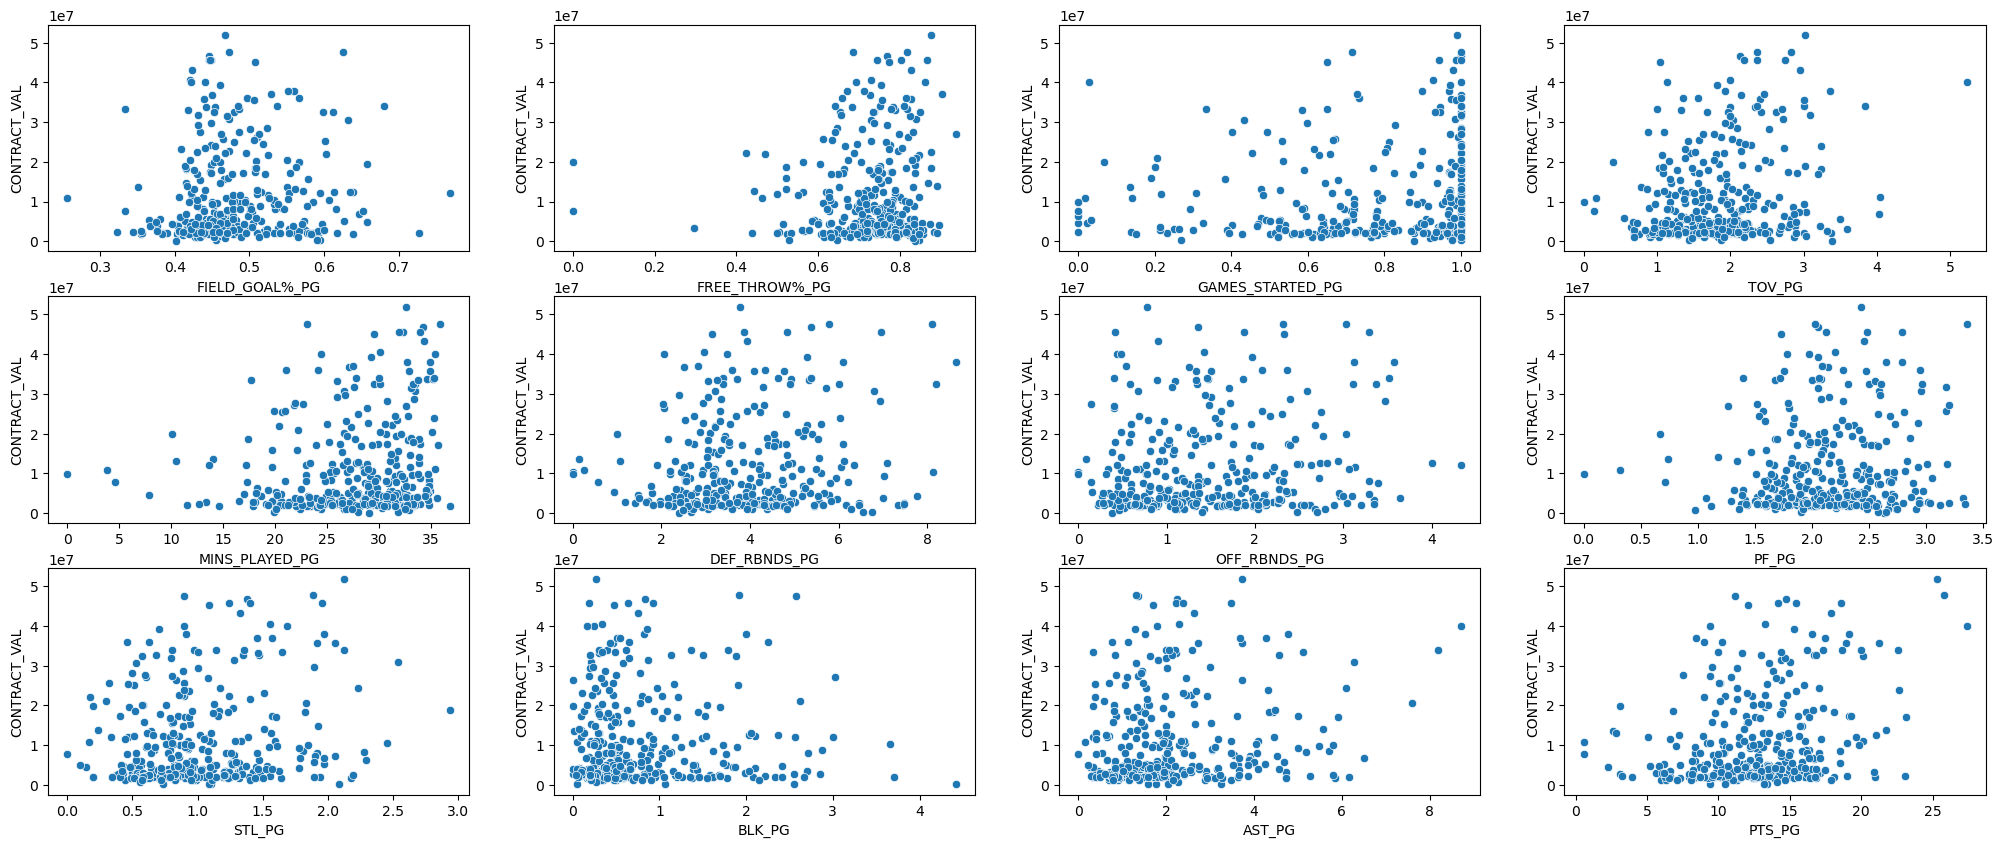

In [22]:
#WE CAN VISUALIZE THE RELATIONSHIPS BETWEEN THE NUMERIC INDEPENDENT VARS WITH CONTRACT VALUE 

fig, axes = plt.subplots(3, 4, figsize=(25, 10))

sns.scatterplot(ax=axes[0, 0], data=reg_df3, x='FIELD_GOAL%_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[0, 1], data=reg_df3, x='FREE_THROW%_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[0, 2], data=reg_df3, x='GAMES_STARTED_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[0, 3], data=reg_df3, x='TOV_PG', y='CONTRACT_VAL')


sns.scatterplot(ax=axes[1, 0], data=reg_df3, x='MINS_PLAYED_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[1, 1], data=reg_df3, x='DEF_RBNDS_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[1, 2], data=reg_df3, x='OFF_RBNDS_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[1, 3], data=reg_df3, x='PF_PG', y='CONTRACT_VAL')


sns.scatterplot(ax=axes[2, 0], data=reg_df3, x='STL_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[2, 1], data=reg_df3, x='BLK_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[2, 2], data=reg_df3, x='AST_PG', y='CONTRACT_VAL')
sns.scatterplot(ax=axes[2, 3], data=reg_df3, x='PTS_PG', y='CONTRACT_VAL')





There is no obvious linear relationship between predictor variables and contract values. However, the scatter plots give us insight into other things:
- The there are outliers in almost every category in which a player with high stat value is on the low-end of contract values. This suggest that certain combinations of skills may be perferred to a high performance in any single statistics. 
- Additionally, thhere maybe perference given to certains skills over others. Players who do well in offensive metrics like points and assissts tend to have a higher contract value than those with high blocks or steals. 

In [23]:
# COMPUTE CORRELATION MATRIX TO CHECK FOR MULTICOLLINEARITY
matrix = reg_df3.corr(numeric_only=True)

<Axes: >

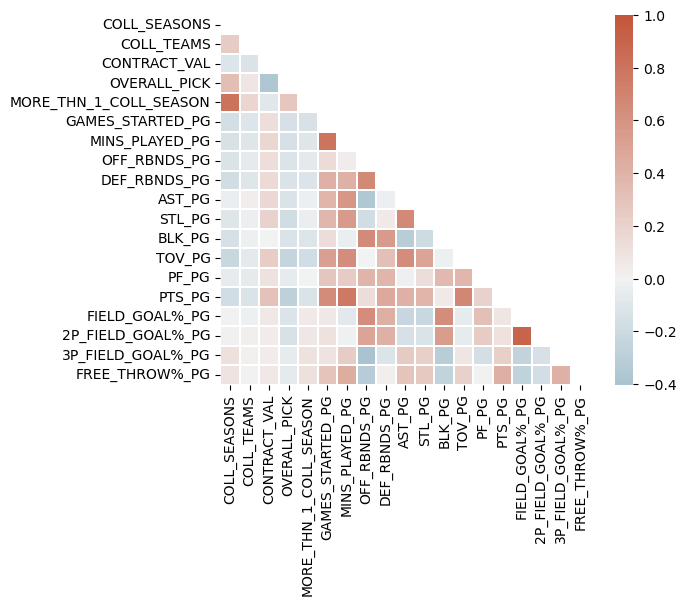

In [24]:
mask = np.triu(np.ones_like(matrix, dtype=bool)) # CREATE MASK TO HIDE TOP HALF OF CORRELATION MATRIX VALUES

# CREATE COLOR PALETTE FOR HEATMAP
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# CREATE HEATMAP
sns.heatmap(matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": 1})

<Axes: >

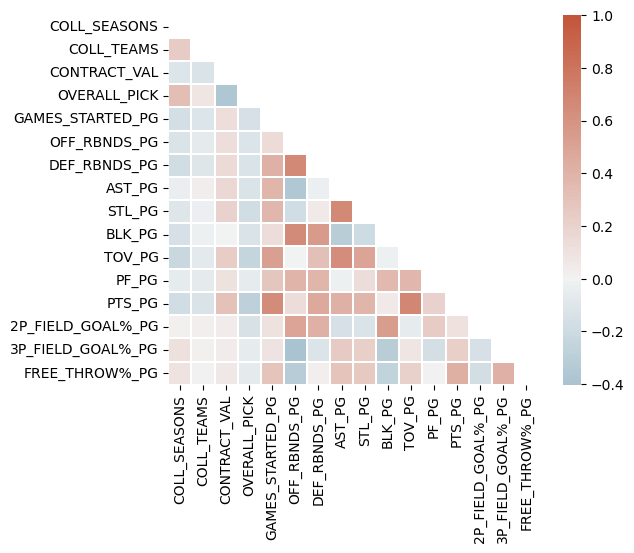

In [25]:
# REMOVE HIGHLY CORRELATED VARIABLES

reg_df4 = reg_df3.drop(['MINS_PLAYED_PG','FIELD_GOAL%_PG','MORE_THN_1_COLL_SEASON'],axis=1)

matrix1 = reg_df4.corr(numeric_only=True)
mask1 = np.triu(np.ones_like(matrix1, dtype=bool)) # CREATE MASK TO HIDE TOP HALF OF CORRELATION MATRIX VALUES

# CREATE COLOR PALETTE FOR HEATMAP
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# CREATE HEATMAP
sns.heatmap(matrix1, mask=mask1, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": 1})

In [26]:
contract_corr = reg_df4.corr(numeric_only=True)['CONTRACT_VAL']
contract_corr


COLL_SEASONS        -0.108582
COLL_TEAMS          -0.125948
CONTRACT_VAL         1.000000
OVERALL_PICK        -0.367914
GAMES_STARTED_PG     0.122603
OFF_RBNDS_PG         0.122220
DEF_RBNDS_PG         0.155811
AST_PG               0.157897
STL_PG               0.196622
BLK_PG              -0.001483
TOV_PG               0.231032
PF_PG                0.097647
PTS_PG               0.302939
2P_FIELD_GOAL%_PG    0.031089
3P_FIELD_GOAL%_PG    0.034810
FREE_THROW%_PG       0.062213
Name: CONTRACT_VAL, dtype: float64

In [27]:
reg_df4.columns

Index(['NAME', 'COLL_SEASONS', 'COLL_TEAMS', 'CONTRACT_VAL', 'DRAFT_SCHOOL',
       'OVERALL_PICK', 'GAMES_STARTED_PG', 'OFF_RBNDS_PG', 'DEF_RBNDS_PG',
       'AST_PG', 'STL_PG', 'BLK_PG', 'TOV_PG', 'PF_PG', 'PTS_PG',
       '2P_FIELD_GOAL%_PG', '3P_FIELD_GOAL%_PG', 'FREE_THROW%_PG'],
      dtype='object')

In [28]:
#CREATE DUMMY VARIABLES FOR DRAFT SCHOOL

dummies = pd.get_dummies(reg_df4[['DRAFT_SCHOOL']],dtype = 'int')
dummies['NAME'] = reg_df4['NAME']


reg_final = pd.merge(reg_df4, dummies, how='left', on='NAME').drop(['NAME','DRAFT_SCHOOL'],axis=1).fillna(0)

In [29]:

dummies.isnull().sum()

DRAFT_SCHOOL_Alabama                0
DRAFT_SCHOOL_Arizona                0
DRAFT_SCHOOL_Arizona State          0
DRAFT_SCHOOL_Arkansas               0
DRAFT_SCHOOL_Auburn                 0
                                   ..
DRAFT_SCHOOL_Wisconsin              0
DRAFT_SCHOOL_Wisconsin-Milwaukee    0
DRAFT_SCHOOL_Wyoming                0
DRAFT_SCHOOL_Xavier                 0
NAME                                0
Length: 98, dtype: int64

## 3. Regression Analysis

While a strong linear relationship between predictor variables and contract value is not obvious. We can fit a linear regression model to evaluate if any of the independent vars may help in predicting potential contract values for new/existing clients. 

In [30]:
cols = list(reg_final.columns)
missing =reg_final.isnull().sum() # MAKRE SURE THERE ARE NO MISSING VALUES
cols

['COLL_SEASONS',
 'COLL_TEAMS',
 'CONTRACT_VAL',
 'OVERALL_PICK',
 'GAMES_STARTED_PG',
 'OFF_RBNDS_PG',
 'DEF_RBNDS_PG',
 'AST_PG',
 'STL_PG',
 'BLK_PG',
 'TOV_PG',
 'PF_PG',
 'PTS_PG',
 '2P_FIELD_GOAL%_PG',
 '3P_FIELD_GOAL%_PG',
 'FREE_THROW%_PG',
 'DRAFT_SCHOOL_Alabama',
 'DRAFT_SCHOOL_Arizona',
 'DRAFT_SCHOOL_Arizona State',
 'DRAFT_SCHOOL_Arkansas',
 'DRAFT_SCHOOL_Auburn',
 'DRAFT_SCHOOL_Baylor',
 'DRAFT_SCHOOL_Belmont',
 'DRAFT_SCHOOL_Boston College',
 'DRAFT_SCHOOL_Bowling Green',
 'DRAFT_SCHOOL_Bucknell',
 'DRAFT_SCHOOL_Butler',
 'DRAFT_SCHOOL_California',
 'DRAFT_SCHOOL_California-Los Angeles',
 'DRAFT_SCHOOL_Central Florida',
 'DRAFT_SCHOOL_Clemson',
 'DRAFT_SCHOOL_Colorado',
 'DRAFT_SCHOOL_Colorado State',
 'DRAFT_SCHOOL_Connecticut',
 'DRAFT_SCHOOL_Creighton',
 'DRAFT_SCHOOL_Davidson',
 'DRAFT_SCHOOL_Dayton',
 'DRAFT_SCHOOL_DePaul',
 'DRAFT_SCHOOL_Duke',
 'DRAFT_SCHOOL_Florida',
 'DRAFT_SCHOOL_Florida State',
 'DRAFT_SCHOOL_Fresno State',
 'DRAFT_SCHOOL_Georgetown',
 'DRAFT_

In [42]:

# DFINE X AND Y FOR MODEL INPUTS
X = reg_final.drop(['CONTRACT_VAL'],axis=1)
y = reg_final['CONTRACT_VAL']
dummies1 = np.array(dummies.drop('NAME', axis=1))

# APPLY SCALER TO CONTINUOUS VARIABLES
scaler = StandardScaler()
X_sc = scaler.fit_transform(X[['COLL_SEASONS', 'COLL_TEAMS', 
       'OVERALL_PICK', 'GAMES_STARTED_PG', 'OFF_RBNDS_PG', 'DEF_RBNDS_PG',
       'AST_PG', 'STL_PG', 'BLK_PG', 'TOV_PG', 'PF_PG', 'PTS_PG',
       '2P_FIELD_GOAL%_PG', '3P_FIELD_GOAL%_PG', 'FREE_THROW%_PG']])

X_sc1 = np.concatenate([X_sc,dummies1],axis=1)



# #add constant to predictor variables
new_X = sma.add_constant(X_sc1)
# #fit linear regression model
model = sma.OLS(y, new_X).fit()



# #view model summary
print(model.summary())

# TO ALIGN COEFFICIENTS WITH VAR NAMES
cols = list(reg_final.drop(['CONTRACT_VAL'],axis=1).columns)
X_sc1_df = pd.DataFrame(X_sc1, columns = cols)
X_sc1_df.head()

                            OLS Regression Results                            
Dep. Variable:           CONTRACT_VAL   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     1.763
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           0.000179
Time:                        22:20:06   Log-Likelihood:                -5892.5
No. Observations:                 339   AIC:                         1.201e+04
Df Residuals:                     227   BIC:                         1.244e+04
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.121e+07   8.54e+05     13.121      0.0

,COLL_SEASONS,COLL_TEAMS,OVERALL_PICK,GAMES_STARTED_PG,OFF_RBNDS_PG,DEF_RBNDS_PG,AST_PG,STL_PG,BLK_PG,TOV_PG,...,DRAFT_SCHOOL_Washington,DRAFT_SCHOOL_Washington State,DRAFT_SCHOOL_Weber State,DRAFT_SCHOOL_West Virginia,DRAFT_SCHOOL_Western Kentucky,DRAFT_SCHOOL_Wichita State,DRAFT_SCHOOL_Wisconsin,DRAFT_SCHOOL_Wisconsin-Milwaukee,DRAFT_SCHOOL_Wyoming,DRAFT_SCHOOL_Xavier
0,-0.989107,-0.231124,-1.166926,0.847219,1.443018,0.979437,-0.116682,-0.260191,0.325402,-0.568917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.739281,-0.231124,0.109381,-0.514420,-1.142661,-0.809375,1.784355,0.478126,-0.788608,1.679819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.124913,-0.231124,-0.495185,-0.232390,-0.553864,0.330682,-0.609604,-0.176383,-0.190121,-0.305455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.739281,-0.231124,2.258949,-0.983271,-0.430872,-0.217551,-0.401022,-0.236096,-0.572034,-0.583119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.989107,-0.231124,-0.360837,-0.524118,-0.798542,-0.491919,-0.807730,-1.059469,-0.311473,-1.729374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cy = list(X_sc1.columns)

In [ ]:
missing =X_sc1_df.isnull().sum()